In [ ]:
import pandas as pd
import re
# coding: utf-8

# 만든 기능 임포트
from crawling import UrlCrawling, ContentCrawling
from preprocessing import Preprocessing
from clustering import Clustering
from summary import Summary
from remove import Remove
from database import insert, selectAll, selectToDay
from tts import tts

In [ ]:
# url 크롤링
url_crawler = UrlCrawling()     # 기사 링크 크롤링 객체

six_url_df = url_crawler.getSixUrl()                            # 6개 카테고리 (카테고리, url 데이터프레임)
entertainment_url_df = url_crawler.getEntertainmentUrl()        # 연예 (카테고리, url 데이터프레임)
sports_url_df = url_crawler.getSportsUrl()                      # 스포츠 (카테고리, url 데이터프레임)

Remove.duplication(six_url_df, entertainment_url_df, sports_url_df)     # 이미 요약한 기사 제거

# 본문 크롤링
six_url, entertainment_url, sports_url = list(six_url_df['six_url']), list(entertainment_url_df['entertainment_url']), list(sports_url_df['sports_url'])
all_url = six_url + entertainment_url + sports_url      # 전체 url
category = list(six_url_df['category']) + list(entertainment_url_df['category']) + list(sports_url_df['category'])

content_crawler = ContentCrawling()     # 기사 크롤링 객체

content_crawler.getSixContent(six_url)                                          # 6개 카테고리 기사 크롤링
content_crawler.getEntertainmentContent(entertainment_url)                      # 연예 기사 크롤링
content_crawler.getSportsContent(sports_url)                                    # 스포츠 기사 크롤링

news_df = content_crawler.makeDataFrame(all_url, category)                      # 본문 데이터프레임 생성

Remove.photoNews(news_df)                                                       # 포토 기사 삭제
Remove.shortNews(news_df)                                                       # 3문장 or 300자 이하 기사 삭제

Preprocessing.getNouns(news_df)                                                 # 명사 추출

Remove.englishNews(news_df)                                                     # 영어 기사 삭제

vector_list = Preprocessing.getVector(news_df)                                  # 명사 벡터화

Clustering.addClusterNumber(news_df, vector_list)                               # 군집 번호 열 생성
cluster_counts_df = Clustering.getClusteredArticle(news_df)                     # 군집 개수 카운트한 df

summary_news = Summary.getSummaryArticle(news_df, cluster_counts_df)            # 기사 요약

Preprocessing.convertCategory(summary_news)                                     # 카테고리 이름 변환

Remove.similarNews(summary_news)                                                # 오늘 요약한 기사와 유사한 기사 drop

In [ ]:
insert(summary_news)

<BarContainer object of 10 artists>

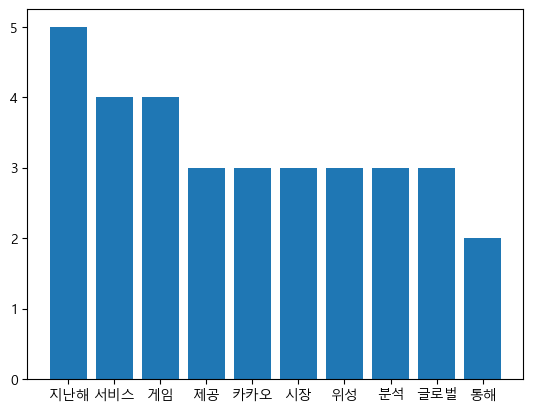

In [38]:
# 키워드 테스트

from collections import Counter
import matplotlib.pyplot as plt

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

df = selectToDay()

result = df['KEYWORD'][df['CATE_ID'] == '105'].str.split(',').explode().tolist()
c = Counter(result).most_common(10)

x = [data[0] for data in c]
y = [data[1] for data in c]

# plt.pie(y, labels=x)
plt.bar(x, y)

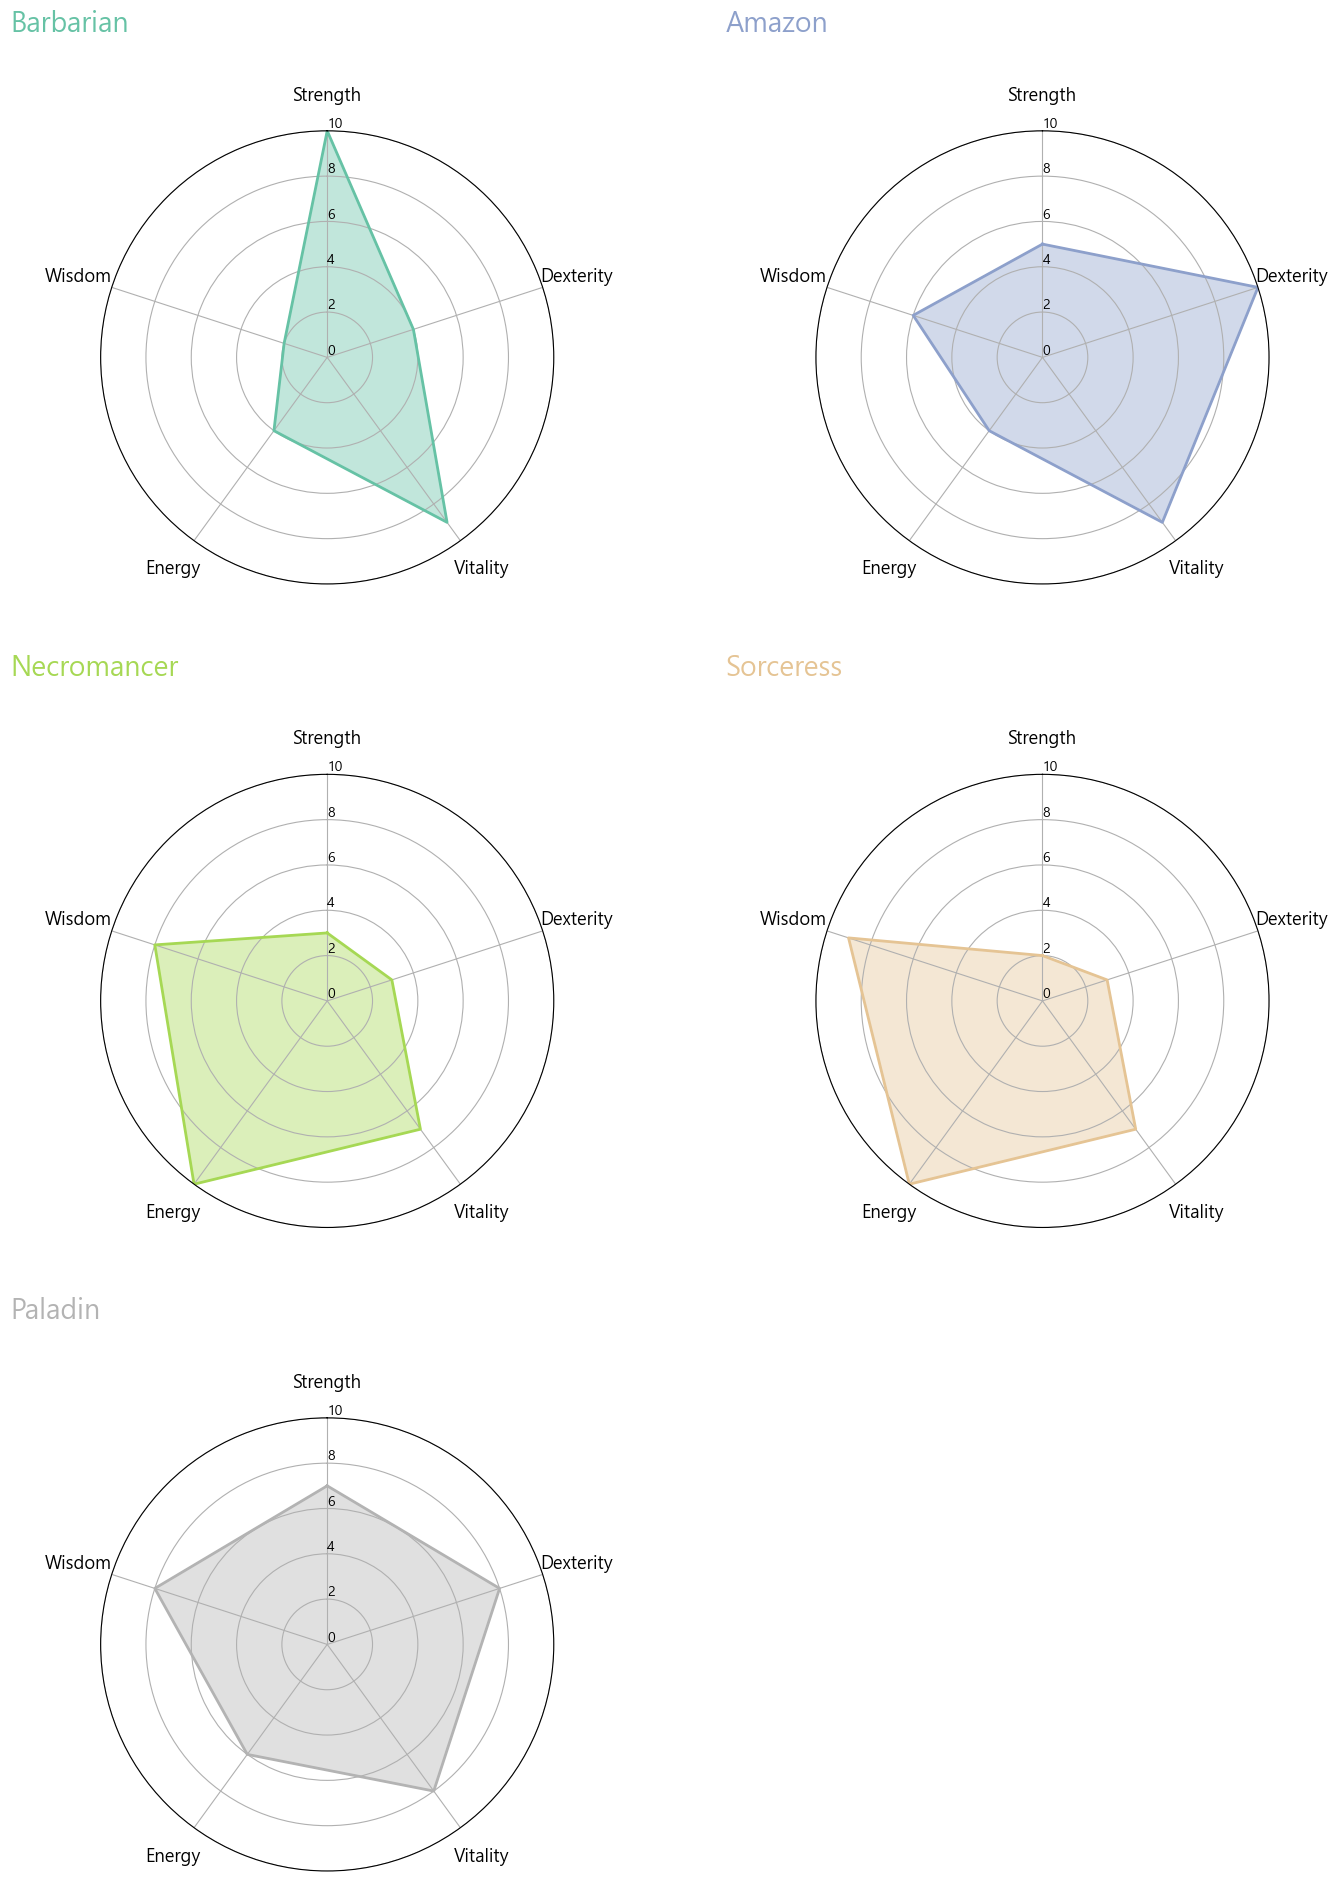

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


## 데이터 준비
df = pd.DataFrame({'Character': ['Barbarian','Amazon','Necromancer','Sorceress','Paladin'],'Strength': [10, 5, 3, 2, 7],'Dexterity': [4, 10, 3, 3, 8],'Vitality': [9, 9, 7, 7, 8],'Energy': [4, 4, 10, 10, 6],'Wisdom': [2, 6, 8, 9, 8]})

## 따로 그리기
labels = df.columns[1:]
num_labels = len(labels)    
angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)] 
## 각 등분점
angles += angles[:1] 
## 시작점으로 다시 돌아와야하므로 시작점 추가    
my_palette = plt.cm.get_cmap("Set2", len(df.index)) 
fig = plt.figure(figsize=(15,20))
fig.set_facecolor('white') 
for i, row in df.iterrows():    
    color = my_palette(i)    
    data = df.iloc[i].drop('Character').tolist()    
    data += data[:1]        
    ax = plt.subplot(3,2,i+1, polar=True)    
    ax.set_theta_offset(pi / 2) 
    ## 시작점    
    ax.set_theta_direction(-1) 
    ## 그려지는 방향 시계방향        
    plt.xticks(angles[:-1], labels, fontsize=13) 
    ## x축 눈금 라벨    
    ax.tick_params(axis='x', which='major', pad=15) 
    ## x축과 눈금 사이에 여백을 준다.     
    ax.set_rlabel_position(0) 
    ## y축 각도 설정(degree 단위)    
    plt.yticks([0,2,4,6,8,10],['0','2','4','6','8','10'], fontsize=10) 
    ## y축 눈금 설정    
    plt.ylim(0,10)        
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid') 
    ## 레이더 차트 출력    
    ax.fill(angles, data, color=color, alpha=0.4) 
    ## 도형 안쪽에 색을 채워준다.        
    plt.title(row.Character, size=20, color=color,x=-0.2, y=1.2, ha='left') 
    ## 타이틀은 캐릭터 클래스로 한다. 

plt.tight_layout(pad=5)
## subplot간 패딩 조절
plt.show()